# Modelo A

Autor: Daniel Triviño

# Setup del cuaderno

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
# import word tokenize
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
nltk.download('punkt_tab')

import spacy
# Load the large spanish model
nlp = spacy.load("es_core_news_lg")
%matplotlib inline

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Entendimiento de los datos

In [2]:
df_original = pd.read_csv('C:/Users/danie/Projects/BI_PROY1_2402/Proyecto 1/Etapa 1/Datasets/ODScat_345.csv', encoding='utf-8')
df_test_original = pd.read_excel('C:/Users/danie/Projects/BI_PROY1_2402/Proyecto 1/Etapa 1/Datasets/TestODScat_345.xlsx')



In [3]:
df_original

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


## Calidad de los datos

Dimensiones de calidad de los datos:
+ Consistencia
+ Validez
+ Completitud
+ Unicidad

### Completitud

Bajo una inspección sencilla, parece no haber problemas de completitud en los datos

In [4]:
df_original['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

In [5]:
# strip all values in the column
df_original['Textos_espanol'] = df_original['Textos_espanol'].str.strip()
# count all values in the column where the value is an empty string

df_original['Textos_espanol'].isnull().sum()

0

### Validez

Se identifican los siguietnes problemas de validez:
+ Hay un problema de codificación de los textos en el dataset, pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [6]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

df_original['Textos_espanol'] = df_original['Textos_espanol'].apply(fix_encoding)

In [7]:
df_original.head(5)

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


### Consistencia

Algunas de las entradas de texto del dataset están rodeadas por comillas dobles, aunque no todas. Es posible que esto no introduzca problemas en el dataset. 

### Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece no haber filas totalmente duplicadas.

In [8]:
df_original.duplicated().sum()

0

## Perfilamiento de los datos

Se aprovecha el paquete ydata-profiling para hacer un perfilamiento detallado del dataset. A partir de este reporte se destacan las siguientes conclusiones:
+ Variables: 2
+ Observaciones: 4049

|Variable|Tipo|
|--|--|
|Textos_espanol|Text|
|sdg|Categórica|

+ Se observa con ayuda del wordcloud que las palabras mas frecuentes en el dataset son stopwords que podrían ser eliminadas en el paso de procesamiento de datos. 


In [9]:
profile = ProfileReport(df_original, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preparación de datos

In [10]:
df_limpieza = df_original.copy(deep=True)
def word_tokenize_spanish(text):
    return word_tokenize(text, language='spanish')
df_limpieza['words'] = df_limpieza['Textos_espanol'].apply(word_tokenize_spanish)
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ..."


In [11]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalpha()]

def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

def preprocessing(words):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

In [12]:
df_limpieza['words'] = df_limpieza['words'].apply(preprocessing)
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financió, directamente, so..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estima, litros, año,..."


In [13]:
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financió, directamente, so..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estima, litros, año,..."


In [14]:
# word cloud
text = ''
for word_list in df_limpieza['words']:
    text += ' '.join(word_list) + ' '

# text = 'monda'

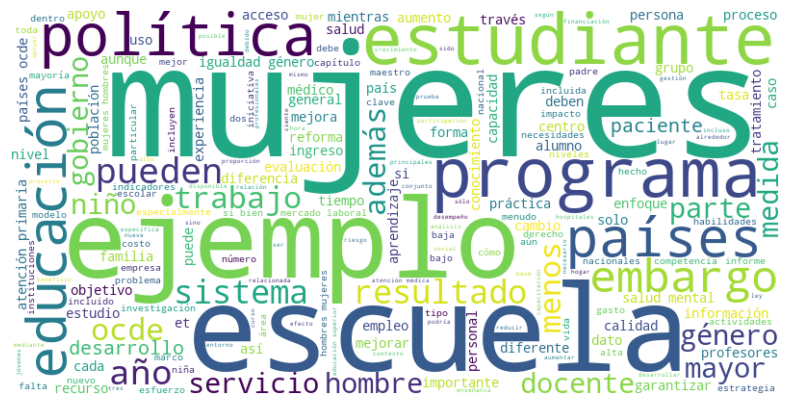

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
def lemmatize(words):
    text = ' '.join(words)
    doc = nlp(text)
    return [token.lemma_ for token in doc]

def stem(words):
    stemmer = nltk.stem.SnowballStemmer('spanish')
    words = [stemmer.stem(word) for word in words]
    return words

def stem_and_lemmatize(words: list[str]):
    # words = stem(words)
    words = lemmatize(words)
    return words


In [17]:
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financió, directamente, so..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estima, litros, año,..."


In [18]:
df_limpieza['words'] = df_limpieza['words'].apply(stem_and_lemmatize)

In [19]:
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consulta, externo, especiali..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financiar, directamente, s..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factor, juego, particular, varied..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, crear, agenci..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estimar, litro, año,..."


In [20]:
df_limpieza['final_text'] = df_limpieza['words'].apply(lambda x: ' '.join(map(str, x)))
X_data, y_data = df_limpieza['final_text'],df_limpieza['sdg']
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_count

(4049, 12449)


<4049x12449 sparse matrix of type '<class 'numpy.int64'>'
	with 187434 stored elements in Compressed Sparse Row format>

In [21]:
X = pd.DataFrame(X_count.toarray(), columns=count.get_feature_names_out())
X

,aalto,aaltonar,aarkrog,aarrevaaro,abajo,abanderado,abandonado,abandonar,abandono,abanico,...,órgano,órganos,úlcera,último,últimos,únicamente,único,úsalo,útero,útil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4045,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
for p in X.columns:
    print(p)

aalto
aaltonar
aarkrog
aarrevaaro
abajo
abanderado
abandonado
abandonar
abandono
abanico
abarcada
abarcar
abbas
abbasian
abbott
abc
abdullah
abiertamente
abierto
abitur
abiyán
abogada
abogado
abogar
abolición
abolido
abolir
abonado
abordada
abordado
abordaje
abordar
abordarla
abordarlos
aborigen
abortir
aborto
aborígenes
aborígén
abouchaar
about
abp
abreviadamente
abriac
abril
abrir
abrumado
abrumador
abruptamente
abrupto
absentismo
absoluto
absolutos
absorber
absorción
absorr
abstemio
abstener
abstracto
abu
abuela
abuelos
abuja
aburrido
aburrimiento
abusada
abusado
abusador
abusar
abusivo
abuso
abyecto
acabar
academia
académicamente
académico
académique
acamo
acar
acaro
acarrear
acceder
accedido
accenture
accesibilidad
accesibl
accesible
acceso
access
accident
accidental
accidente
accionista
acción
accra
accrott
ace
acecho
aceitero
aceleración
acelerar
acemoglu
acentuado
acentuar
aceptabilidad
aceptable
aceptación
aceptado
aceptar
acerca
acercar
acertadamente
acertado
achacar
achievem

In [23]:
# Import a decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Split the data into a training and a test set
training_data = X
training_data['category'] = y_data

X_train, X_test, y_train, y_test = train_test_split(training_data.drop('category', axis=1), training_data['category'], test_size=0.2, random_state=42)

# Create the decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set
y_pred = clf.predict(X_test)

In [24]:
# Calculate the accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9444444444444444

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.92      0.96      0.94       250
           4       0.96      0.94      0.95       268
           5       0.95      0.94      0.95       292

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.95      0.94      0.94       810



In [26]:
# Import a random forest
from sklearn.ensemble import RandomForestClassifier

# Create the random forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set
y_pred = clf.predict(X_test)

In [27]:
# Calculate the accuracy
accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.98      0.99      0.98       250
           4       0.97      0.98      0.97       268
           5       0.98      0.97      0.97       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810

